# 📚 Image Captioning Challenge 📚

## 0-Imports



In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch
from tqdm import tqdm
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
import numpy as np
import os

## 1- Data Reading

In [13]:
#from google.colab import drive
#drive.mount('/content/drive')
#
#!unzip -q "/content/drive/MyDrive/caption_dataset/caption_dataset.zip" -d "/content/dataset/"

# === Notebook Constants ===
DATASET_PATH = "dataset/"
TRAIN_CSV = os.path.join(DATASET_PATH, "train.csv")
TEST_CSV = os.path.join(DATASET_PATH, "test.csv")
SUBMISSION_FILE = "submission.csv"

# === Data Loading and Basic Exploration ===
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
train_df.head()


Train shape: (21367, 2), Test shape: (3771, 1)


,image_id,caption
0,0,The image features a comic-style panel depicti...
1,1,"Colorful postcard featuring ""Greetings from Ch..."
2,2,Two vending machines display a variety of drin...
3,3,A man speaks at the eGovernment Conference 201...
4,4,A close-up of several silver coins stacked tog...


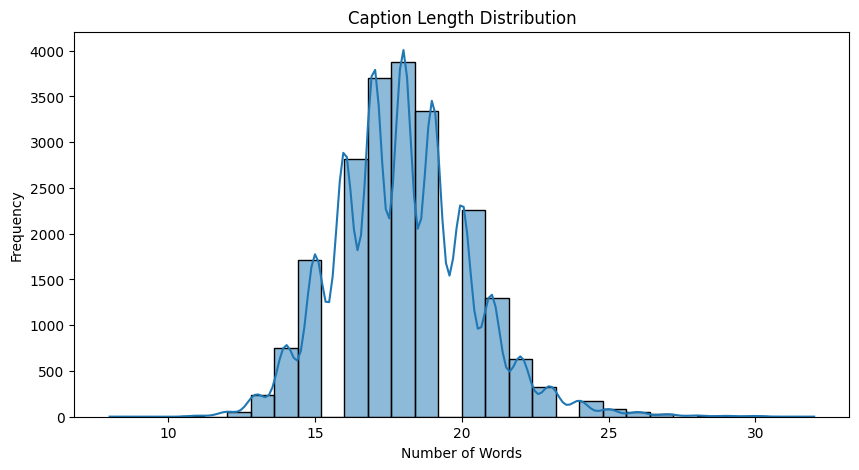

Unique captions: 21367
Average caption length: 17.971732110263492


In [14]:
train_df['caption_length'] = train_df['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,5))
sns.histplot(train_df['caption_length'], bins=30, kde=True)
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()
print("Unique captions:", train_df['caption'].nunique())
print("Average caption length:", train_df['caption_length'].mean())


Image not found: /content/dataset/train/train/9119.jpg
Image not found: /content/dataset/train/train/4904.jpg
Image not found: /content/dataset/train/train/4272.jpg
Image not found: /content/dataset/train/train/16161.jpg
Image not found: /content/dataset/train/train/14729.jpg


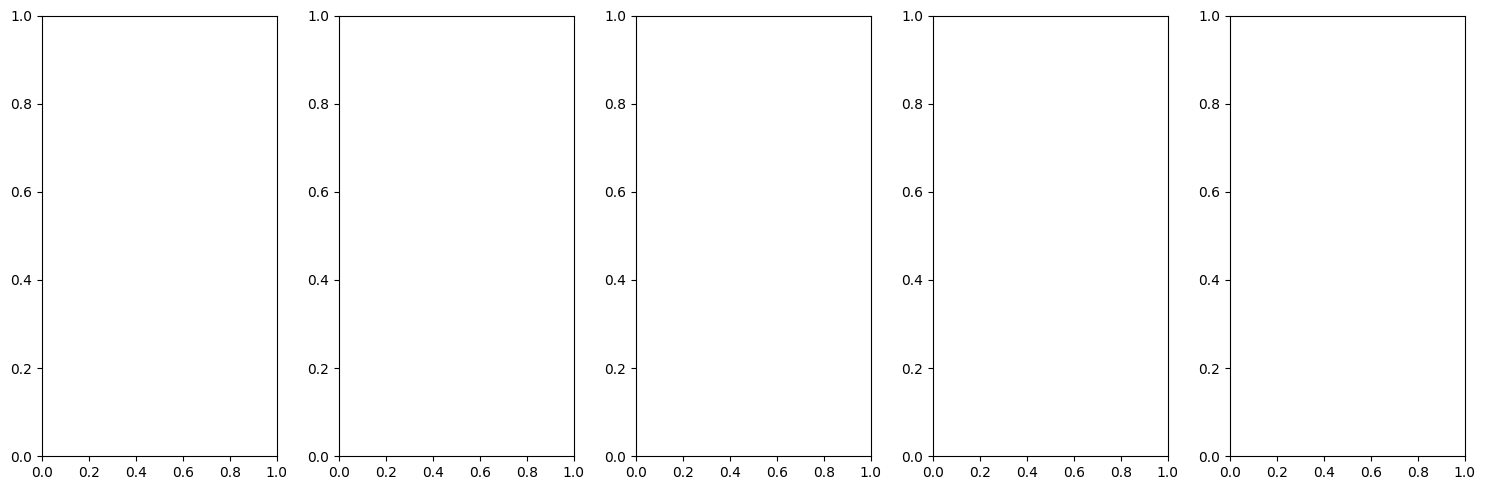

Image not found: /content/dataset/train/train/15974.jpg
Image not found: /content/dataset/train/train/17782.jpg
Image not found: /content/dataset/train/train/4257.jpg
Image not found: /content/dataset/train/train/8799.jpg
Image not found: /content/dataset/train/train/6857.jpg


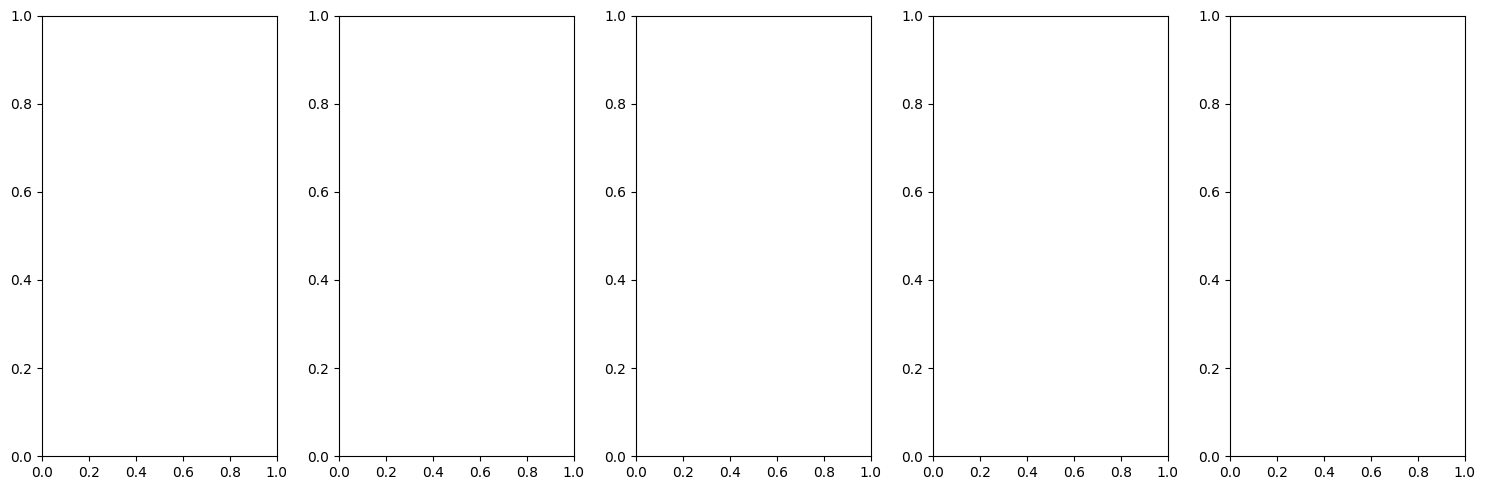

In [15]:
def show_random_examples(df, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 5))
    for i in range(n):
        row = df.sample(1).iloc[0]
        img_filename = f"{row['image_id']}.jpg"
        img_path = f"/content/dataset/train/train/{img_filename}"
        if not os.path.exists(img_path):
            print(f"Image not found: {img_path}")
            continue
        image = Image.open(img_path).convert("RGB")
        axes[i].imshow(image)
        axes[i].axis("off")
        axes[i].set_title("\n".join(row['caption'].split()[:8]))
    plt.tight_layout()
    plt.show()

show_random_examples(train_df, 5)
show_random_examples(train_df, 5)

In [16]:
print("Unique captions:", train_df['caption'].nunique())
print("Average caption length:", train_df['caption_length'].mean())


Unique captions: 21367
Average caption length: 17.971732110263492


## 2- Data Preprocessing and Modelling

In [17]:
from transformers import Blip2Processor, Blip2ForConditionalGeneration, Trainer, TrainingArguments
from PIL import Image
import os
import torch

# Disable W&B to avoid prompts or usage
os.environ["WANDB_DISABLED"] = "true"

# Load processor and model (no HF_TOKEN needed, using public pretrained models)
processor_blip = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    device_map="auto",
    torch_dtype=torch.float16
)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare dataset paths and captions
train_df['caption_proc'] = train_df['caption'].apply(lambda x: "<start> " + x.strip() + " <end>")
image_dir = os.path.join(DATASET_PATH, "train", "train")
image_ids = train_df['image_id'].tolist()
captions = train_df['caption_proc'].tolist()

# CustomDataset with disk-based image loading (safe fallback for corrupted/missing images)
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, processor, image_ids, captions, image_dir):
        self.processor = processor
        self.image_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in image_ids]
        self.captions = captions

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB").resize((224, 224))
        except Exception as e:
            print(f"Image not found or corrupted: {self.image_paths[idx]}")
            image = Image.new("RGB", (224, 224), color='white')  # Fallback to blank image

        inputs = self.processor(
            images=image,
            text=self.captions[idx],
            return_tensors="pt",
            padding="max_length",
            max_length=32,
            truncation=True
        )
        return {k: v.squeeze() for k, v in inputs.items()}

train_dataset_blip = CustomDataset(processor_blip, image_ids, captions, image_dir)

# Training arguments
training_args_blip = TrainingArguments(
    output_dir="./blip2-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=100,
    save_total_limit=2
)

# Trainer and training
trainer_blip = Trainer(
    model=blip2_model,
    args=training_args_blip,
    train_dataset=train_dataset_blip
)
trainer_blip.train()
blip2_model.save_pretrained("./blip2-finetuned")


ValueError: Using a `device_map`, `tp_plan`, `torch.device` context manager or setting `torch.set_default_device(device)` requires `accelerate`. You can install it with `pip install accelerate`

In [ ]:
#Fine-Tuning GPT-2 with TextDataset and Trainer
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling

# Load tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# Save captions to a temporary txt file
train_text_file = "train_captions.txt"
with open(train_text_file, "w", encoding="utf-8") as f:
    for caption in train_df['caption_proc']:
        f.write(caption + "\n")

# Create TextDataset for GPT-2
dataset = TextDataset(
    tokenizer=gpt2_tokenizer,
    file_path=train_text_file,
    block_size=128
)

# Data collator for LM
data_collator = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer,
    mlm=False
)

# Training arguments
training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    save_steps=100,
    save_total_limit=2,
    logging_steps=50,
    prediction_loss_only=True
)

# Trainer
trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    data_collator=data_collator,
    train_dataset=dataset
)

# Train GPT-2
trainer_gpt2.train()
gpt2_model.save_pretrained("./gpt2-finetuned")

In [ ]:
#Load CLIP Processor and Model (Pretrained, No Fine-Tune)
from transformers import CLIPProcessor, CLIPModel
processor_clip = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)

## 3-Creating Captions For submission.csv

In [ ]:
#Caption generation with Fine-Tuned BLIP-2
submission_blip2 = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"): img_id += ".jpg"
    img_path = os.path.join(DATASET_PATH, "test", "test", img_id)
    try:
        image = Image.open(img_path).convert("RGB").resize((224,224))
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue
    inputs = processor_blip(images=image, return_tensors="pt").to(device, torch.float16)
    with torch.no_grad():
        ids = blip2_model.generate(
            **inputs,
            max_length=40
        )
    caption = processor_blip.tokenizer.decode(ids[0], skip_special_tokens=True)
    submission_blip2.append({"image_id": img_id, "caption": caption})
submission_df = pd.DataFrame(submission_blip2)
submission_df.to_csv("submission_blip2_finetune.csv", index=False)
print("submission_blip2_finetune.csv created.")
submission_df.head()

In [ ]:
#Advanced Decoding for Better Captions with Fine-Tuned BLIP-2
submission_advanced_blip2 = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"):
        img_id += ".jpg"
    img_path = os.path.join(DATASET_PATH, "test", "test", img_id)
    try:
        image = Image.open(img_path).convert("RGB").resize((224,224))
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue
    inputs = processor_blip(images=image, return_tensors="pt").to(device, torch.float16)
    with torch.no_grad():
        generated_ids = blip2_model.generate(
            **inputs,
            max_length=40,
            num_beams=10,   # Beam search for diversity
            top_k=30,       # Top-k sampling
            top_p=0.85,     # Nucleus sampling
            temperature=0.6,
            repetition_penalty=1.5,
            early_stopping=True
        )
    caption = processor_blip.tokenizer.decode(generated_ids[0], skip_special_tokens=True).strip().capitalize()
    if len(caption.split()) < 10:
        caption = "A detailed scene with various objects."
    elif len(caption.split()) > 25:
        caption = " ".join(caption.split()[:25]) + "."
    submission_advanced_blip2.append({"image_id": img_id, "caption": caption})

submission_df = pd.DataFrame(submission_advanced_blip2)
submission_df.to_csv("submission_blip2_advanced.csv", index=False)
print("submission_blip2_advanced.csv created.")
submission_df.head()

In [ ]:
#Caption generation with Fine-Tuned GPT-2
submission_gpt2 = []
prompt = "An image showing"
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"): img_id += ".jpg"
    img_path = os.path.join(DATASET_PATH, "test", "test", img_id)
    try:
        image = Image.open(img_path).convert("RGB").resize((224,224))
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue
    input_ids = gpt2_tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs = gpt2_model.generate(
            input_ids,
            max_length=40
        )
    caption = gpt2_tokenizer.decode(outputs[0], skip_special_tokens=True)
    submission_gpt2.append({"image_id": img_id, "caption": caption})
submission_df = pd.DataFrame(submission_gpt2)
submission_df.to_csv("submission_gpt2_finetune.csv", index=False)
print("submission_gpt2_finetune.csv created.")
submission_df.head()

In [ ]:
# Fine-Tuning BLIP-2 with LoRA (PEFT) - Efficient for Colab Free Tier
from transformers import Blip2Processor, Blip2ForConditionalGeneration, Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, TaskType
from PIL import Image
import os
import torch

# Load processor and model
processor_blip = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
blip2_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b",
    torch_dtype=torch.float16
)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Prepare dataset paths and captions
train_df['caption_proc'] = train_df['caption'].apply(lambda x: "<start> " + x.strip() + " <end>")
image_dir = os.path.join(DATASET_PATH, "train", "train")
image_ids = train_df['image_id'].tolist()
captions = train_df['caption_proc'].tolist()

# CustomDataset with disk-based image loading
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, processor, image_ids, captions, image_dir):
        self.processor = processor
        self.image_paths = [os.path.join(image_dir, f"{img_id}.jpg") for img_id in image_ids]
        self.captions = captions
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB").resize((224,224))
        except Exception as e:
            print(f"Image not found or corrupted: {self.image_paths[idx]}")
            image = Image.new("RGB", (224,224), color='white')  # Fallback to blank image
        inputs = self.processor(
            images=image,
            text=self.captions[idx],
            return_tensors="pt",
            padding="max_length",
            max_length=32,
            truncation=True
        )
        return {k: v.squeeze() for k, v in inputs.items()}

train_dataset_blip = CustomDataset(processor_blip, image_ids, captions, image_dir)

# Apply LoRA PEFT to BLIP-2
peft_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none"
)
blip2_model = get_peft_model(blip2_model, peft_config)
blip2_model.print_trainable_parameters()

# Training arguments
training_args_blip = TrainingArguments(
    output_dir="./blip2-finetuned",
    per_device_train_batch_size=2,
    num_train_epochs=3,
    save_steps=100,
    save_total_limit=2,
    logging_steps=50,
    fp16=True
)

# Trainer and training
trainer_blip = Trainer(
    model=blip2_model,
    args=training_args_blip,
    train_dataset=train_dataset_blip
)
trainer_blip.train()

# Save LoRA fine-tuned model
blip2_model.save_pretrained("./blip2-finetuned")


model.safetensors.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

In [ ]:
#Ensemble of Fine-Tuned BLIP-2 + GPT-2 + CLIP (with Advanced Decoding)
submission_ensemble = []
for _, row in tqdm(test_df.iterrows(), total=len(test_df)):
    img_id = str(row["image_id"])
    if not img_id.endswith(".jpg"):
        img_id += ".jpg"
    img_path = os.path.join(DATASET_PATH, "test", "test", img_id)
    try:
        image = Image.open(img_path).convert("RGB").resize((224,224))
    except Exception as e:
        print(f"Image not found or corrupted: {img_path}")
        continue

    # BLIP-2 caption (advanced decoding)
    inputs_blip = processor_blip(images=image, return_tensors="pt").to(device, torch.float16)
    with torch.no_grad():
        ids_blip = blip2_model.generate(
            **inputs_blip,
            max_length=40,
            num_beams=10,
            top_k=30,
            top_p=0.85,
            temperature=0.6,
            repetition_penalty=1.5,
            early_stopping=True
        )
    caption_blip = processor_blip.tokenizer.decode(ids_blip[0], skip_special_tokens=True)

    # GPT-2 caption (advanced decoding)
    input_ids = gpt2_tokenizer("An image showing", return_tensors="pt").input_ids.to(device)
    with torch.no_grad():
        outputs_gpt2 = gpt2_model.generate(
            input_ids,
            max_length=40,
            num_beams=10,
            top_k=30,
            top_p=0.85,
            temperature=0.6,
            repetition_penalty=1.5,
            early_stopping=True
        )
    caption_gpt2 = gpt2_tokenizer.decode(outputs_gpt2[0], skip_special_tokens=True)

    # CLIP embedding (for potential ranking or weighting)
    inputs_clip = clip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs_clip = clip_model(**inputs_clip)
    embedding_clip = outputs_clip.logits_per_image

    # Combine captions: choose longer or better
    if len(caption_blip) > len(caption_gpt2):
        final_caption = caption_blip
    else:
        final_caption = caption_gpt2

    # Final caption refinement
    final_caption = final_caption.strip().capitalize()
    if len(final_caption.split()) < 10:
        final_caption = "A detailed scene with various objects."
    elif len(final_caption.split()) > 25:
        final_caption = " ".join(final_caption.split()[:25]) + "."

    submission_ensemble.append({"image_id": img_id, "caption": final_caption})

submission_df = pd.DataFrame(submission_ensemble)
submission_df.to_csv("submission.csv", index=False)
print("submission.csv created.")
submission_df.head()

## 5- CALCULATE FGD SCORE

In [ ]:
"""
This metric implements the mean Fréchet GTE Distance (FGD) score for text embeddings using the GTE-small model.
The metric measures the similarity between ground truth and predicted text captions by comparing their embedding distributions.

The score is calculated by:
1. Converting text to embeddings using GTE-small
2. Computing mean and covariance statistics of the embeddings
3. Calculating the FGD score between the distributions
"""

import pandas as pd
import pandas.api.types
import numpy as np
from numpy import cov, trace, iscomplexobj
from scipy.linalg import sqrtm
from typing import List
from sentence_transformers import SentenceTransformer

def calculate_fgd(solution_embed: np.ndarray, submission_embed: np.ndarray) -> float:
    '''
    solution_embed: Embedding of the ground truth from GTE-small.
    submission_embed: Embedding of the predicted caption from GTE-small.
    '''
    fgd_list = []
    for _idx, (sol_emb_sample, sub_emb_sample) in enumerate(zip(solution_embed, submission_embed)):
        sol_emb_sample_rshaped, sub_emb_sample_rshaped = sol_emb_sample.reshape((1,384)), sub_emb_sample.reshape((1,384))
        e1 = np.concatenate([sol_emb_sample_rshaped, sol_emb_sample_rshaped])
        e2 = np.concatenate([sub_emb_sample_rshaped, sub_emb_sample_rshaped])
        """Calculate Fréchet GTE Distance between two embedding distributions"""
        # Calculate mean and covariance statistics
        mu1, sigma1 = e1.mean(axis=0), cov(e1, rowvar=False)
        mu2, sigma2 = e2.mean(axis=0), cov(e2, rowvar=False)

        # Calculate sum squared difference between means
        ssdiff = np.sum((mu1 - mu2)**2.0)

        # Calculate sqrt of product between cov
        covmean = sqrtm(sigma1.dot(sigma2))

        # Check and correct imaginary numbers from sqrt
        if iscomplexobj(covmean):
            covmean = covmean.real

        # Calculate score
        fgd = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
        fgd_list.append(fid)
        if _idx % 100 == 0:
            print(f"Processed {_idx} samples", end="\r")
    return float(np.mean(fgd_list))


In [ ]:
gte_model = SentenceTransformer("thenlper/gte-small")

# Ground truth
gt_df = pd.read_csv("/content/dataset/train.csv")
gt_captions = gt_df["caption"].values
gt_embed = gte_model.encode(list(gt_captions), batch_size=64, show_progress_bar=True)

In [ ]:
submission_files = [
    ("submission_blip2_finetune.csv", "BLIP-2 Fine-Tuned"),
    ("submission_blip2_advanced.csv", "BLIP-2 Advanced"),
    ("submission_gpt2_finetune.csv", "GPT-2 Fine-Tuned"),
    ("submission_gpt2_advanced.csv", "GPT-2 Advanced"),
    ("submission.csv", "Ensemble (BLIP-2 + GPT-2 + CLIP)")
]

for file_name, model_name in submission_files:
    pred_df = pd.read_csv(file_name)
    N = min(len(gt_df), len(pred_df))
    pred_captions = pred_df["caption"].values[:N]
    pred_embed = gte_model.encode(list(pred_captions), batch_size=64, show_progress_bar=True)
    fgd_score = calculate_fgd(gt_embed[:N], pred_embed)
    print(f"\nFGD Score for {model_name}: {fgd_score:.4f}")

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd

DATASET_PATH = "/content/dataset/test/test"
submission_df = pd.read_csv("submission.csv")

print("\n🎥 Random 50 Sample Outputs with Images (Ensemble Model):\n")
sample_df = submission_df.sample(50, random_state=42)

rows, cols = 10, 5
fig, axes = plt.subplots(rows, cols, figsize=(20, 40))
axes = axes.flatten()

for ax, (_, row) in zip(axes, sample_df.iterrows()):
    img_path = os.path.join(DATASET_PATH, row['image_id'])
    try:
        image = Image.open(img_path).convert("RGB")
        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"{row['caption']}", fontsize=6)
    except:
        ax.axis("off")
        ax.set_title("Image not found", fontsize=6)

plt.tight_layout()
plt.show()